In [29]:
import networkx as nx
import pandas as pd
from tqdm import tqdm_notebook,tqdm
import numpy as np
import parmap
import json
parent_path='Data/'


In [30]:
with open(parent_path+'users_information.json', 'r') as fp:
    dict_users=json.load(fp)

In [31]:

import json
with open(parent_path+'fear_speech_data.json', 'r') as fp:
    fear_speech_data=json.load(fp)

In [32]:
fear_speech_data['0']

{'message_text': '*प्रशासक समिति*✊🚩  ●●●●●●●●●●● ● ● ● 😎🚩 *आंतकवादी संगठनों का💣🔪 इस्लामिक नाम और उनका इस्लाम.....* *धर्म से जुड़ा हुआ अर्थ...* 🐖🐖🐖 *1.लश्करे तैयबा-फरिश्तो की सेना* *2.अल कायदा-अल्लाह का कायदा...* *3.जेश ए मोहम्द-मोहम्मद साहेब का दल...* *4.तहरिक ए तालिबान-पवित्र योद्धाओ का दल...* *5.हिजबुल मुजादिन-इस्लामी बलिदानियो का समूह...* *6.बोको हराम -पैगम्बर मुहम्मद की शिक्षा को फैलाने के लिए प्रतिबद्ध..* *सभी मुस्लमान अज्ञानि अल्लाह की बताई हुई रूहानी किताब क़ुरआन की बताई राह* *(पूरी दुनिया को इस्लाम बनाना)पर ही चल रहे है कोई ज्यादा बच👨\u200d👨\u200d👦* *पैदा करके तो कोई लव जिहाद👫 करके तो कोई काफ़िर(गेर मुसलमान)को मारकर..* *धरती पर आंतक🔫💣💣💣🔫फेला रहे है\ufeff।।* 😡😡😡😎😡😡😡  *जय सनातन धर्म की*🚩🚩🚩  🙏🚩🇮🇳🔱🏹🐚🕉',
 'translated_text': '* Administrator ✊ 🚩   Committee * ● ●●●●●●●●●● 🚩  😎  ● ● ● नाम 🔪  💣  * Islamic name of terrorist organizations and their meaning 🐖  🐖  🐖  in Islam… .. * Religion… * ... 1. * 1. Army of Lashkar-e-Taiba-Farishto * * 2. Al Qaeda-Qaeda of Allah ... * * 3. Team of Jesh-

In [18]:
df_user_matched=pd.read_csv('Data/final_user_selection_matched.csv')

In [21]:
len(df_user_matched[df_user_matched['annotation']=='Non fear speech'])

2932

In [11]:
tuples_user_info=[]

list_users= list(dict_users.keys())
for i in tqdm(range(len(list_users))):
    for j in range(i,len(list_users)):
        if(i==j):
            continue
        temp_user1_groups= set(dict_users[str(list_users[i])]['group_the_user_participate'])
        temp_user2_groups= set(dict_users[str(list_users[j])]['group_the_user_participate'])
        
        
        common_groups=len(temp_user1_groups.intersection(temp_user2_groups))
        if(common_groups>0):
            tuples_user_info.append([list_users[i],list_users[j],common_groups])

100%|██████████| 109542/109542 [2:03:31<00:00, 14.78it/s]  


In [12]:
import networkx as nx

In [13]:
G = nx.Graph()

In [15]:
G.add_weighted_edges_from(tuples_user_info)

In [133]:
nx.write_weighted_edgelist(G, "Networks/users_network.edgelist.gz")

### Load precomputed

In [134]:
# import json

# with open("Networks/user_dict.json", 'r') as fp:
#     dict_users_ids=json.load(fp)
# with open("Networks/user_labels_dict.json", 'r') as fp:
#     dict_users_names=json.load(fp)

    
G_new=nx.read_weighted_edgelist("Networks/users_network.edgelist.gz")
    

In [23]:
dict_users_ids={}
list_users= list(dict_users.keys())
for i in tqdm(range(len(list_users))):
    dict_users_ids[dict_users[str(i)]['user_id']]=str(i)

100%|██████████| 109542/109542 [00:00<00:00, 624287.43it/s]


In [135]:
k_cores=nx.algorithms.core.core_number(G_new)

In [42]:
dict_user_num_messages={}
dict_group_num_messages={}

for key in tqdm_notebook(fear_speech_data.keys(),total=len(fear_speech_data)):
    element = fear_speech_data[key]
    
    count_fearspeech=element['annotation_list'].count('Fear speech')
    count_normal=element['annotation_list'].count('Normal')
    
    if(count_fearspeech>count_normal):
        for ele in element['propagation']:
            try:
                dict_user_num_messages[ele['user_id']]+=1
            except KeyError:
                dict_user_num_messages[ele['user_id']]=1
            try:
                dict_group_num_messages[ele['group_id']]+=1
            except KeyError:
                dict_group_num_messages[ele['group_id']]=1





/home/punyajoy/.conda/envs/punyajoy_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [44]:
dict_user_num_messages_sorted={k: v for k, v in sorted(dict_user_num_messages.items(), key=lambda item: item[1],reverse=True)}

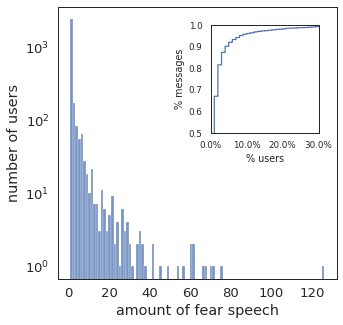

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.ticker as mtick
matplotlib.rcParams['figure.figsize'] = (5, 5)
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}

ax = sns.histplot(x=list(dict_user_num_messages.values()),bins=100)
plt.xlabel('amount of fear speech')
plt.ylabel('number of users')
plt.yscale('log')



sns.set(context='paper',style='white',font_scale=1.0)

ax2 = plt.axes([0.55, 0.53, .3, .3])
sns.ecdfplot(x=list(dict_user_num_messages_sorted.values()),ax=ax2)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter())

plt.xlim(left=0,right=30)
plt.ylim(bottom=0.5,top=1)


plt.xlabel('% users')
plt.ylabel('% messages')


plt.savefig('../Fear_speech_results/fear_speech_per_users.pdf',bbox_inches='tight',dpi=400)

plt.show()

In [105]:
list_cores_fs=[]
list_cores_nfs=[]
for index,row in df_user_matched.iterrows():
    if(row['annotation']=="Fear speech"):
        try:
            list_cores_fs.append(k_cores[dict_users_ids[row['user_id']]])
        except KeyError:
            list_cores_fs.append(0)
    else:
        try:
            list_cores_nfs.append(k_cores[dict_users_ids[row['user_id']]])
        except KeyError:
            list_cores_nfs.append(0)

In [136]:
from statistics import mean, stdev
from math import sqrt

# test conditions
c0 = list_cores_fs
c1 = list_cores_nfs

cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))

print(cohens_d)

0.18155984866426092


In [108]:
len(list_cores_fs)

2932

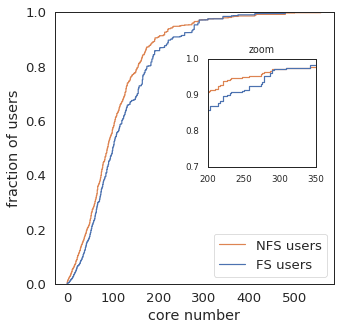

In [131]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)

#     'weight' : 'normal',
#     'size'   : 15}
# matplotlib.rc('font', **font)
#data_timeline.plot()
sns.set(context='paper',style='white',font_scale=1.5)

font = {
    'weight' : 'normal',
    'size'   : 11}
#ax = sns.histplot(x=list_cores_nfs,bins=50,color='#DE8F05')
ax=sns.ecdfplot(x=list_cores_nfs,color=sns.color_palette()[1])
ax=sns.ecdfplot(x=list_cores_fs,color=sns.color_palette()[0])

plt.xlabel('core number')
plt.ylabel('fraction of users')
#ax.set(ylim=(0, 1000))
plt.legend(['NFS users','FS users'])

sns.set(context='paper',style='white',font_scale=1.0)

ax2 = plt.axes([0.55, 0.45, .3, .3])
sns.ecdfplot(x=list_cores_nfs,color=sns.color_palette()[1], ax=ax2)
sns.ecdfplot(x=list_cores_fs,color=sns.color_palette()[0],ax=ax2)

ax2.set_title('zoom')
ax2.set_xlim([200,350])
ax2.set_ylim([0.7,1])
plt.ylabel('')
#plt.yscale('log')
plt.savefig('../Fear_speech_results/kcore_cdf.pdf',bbox_inches='tight',dpi=400)

plt.show()

In [127]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu

seed(1)
stat, p = mannwhitneyu(list_cores_fs, list_cores_nfs)

In [129]:
print('Statistics=%.3f, p=%.6f' % (stat, p))

Statistics=3794736.500, p=0.000000
